In [ ]:
#Getting data from Kaggle

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sales-data-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1525710%2F2518637%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T022152Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8b662adfc8ab7ca8c9063be7580ddef1292d6ee1cb0e81496a25f72e14fcdd9f84c78af8eb5895c62846c0ce0579ea9653c42547ab1ece475def903065e11a964b9d34837689081d775a7ff1eeecfbdca13bc0b85ac032e59d5d098c1b61d45ab5aab5bf160e9b4e445bc8e21e61b5430504a1f5f2465f2db8b63015d7acd2a649c4d0d406da82578ef876b683ef3dd2c8ec10f487ab8461c55ab7f5695e413593bb108a00b967226f9ec3e70f7f72120a99b471db1a9078c3425704c3da89a56f7a01cb0921b03c125dc6048ff9ef4dd7a97a15a2038883959af60fcf8d8c2b13ee51a0d2e5620664bba6a29abcdb097e89ad8a8db85df18d51da8403fc2dd7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3818135 bytes downloaded
Downloaded and uncompressed: sales-data-analysis
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sales-data-analysis/Sales Data.csv


#Exploring the Dataset


In [ ]:

df = pd.read_csv("/kaggle/input/sales-data-analysis/Sales Data.csv")
df

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0
1,1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7
2,2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18
3,3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15
4,4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12
...,...,...,...,...,...,...,...,...,...,...,...
185945,13617,222905,AAA Batteries (4-pack),1,2.99,2019-06-07 19:02:00,"795 Pine St, Boston, MA 02215",6,2.99,Boston,19
185946,13618,222906,27in FHD Monitor,1,149.99,2019-06-01 19:29:00,"495 North St, New York City, NY 10001",6,149.99,New York City,19
185947,13619,222907,USB-C Charging Cable,1,11.95,2019-06-22 18:57:00,"319 Ridge St, San Francisco, CA 94016",6,11.95,San Francisco,18
185948,13620,222908,USB-C Charging Cable,1,11.95,2019-06-26 18:35:00,"916 Main St, San Francisco, CA 94016",6,11.95,San Francisco,18


In [ ]:
df.head()

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0
1,1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7
2,2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18
3,3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15
4,4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12


In [ ]:
df.columns

Index(['Unnamed: 0', 'Order ID', 'Product', 'Quantity Ordered', 'Price Each',
       'Order Date', 'Purchase Address', 'Month', 'Sales', 'City', 'Hour'],
      dtype='object')

In [ ]:
df.columns

Index(['Unnamed: 0', 'Order ID', 'Product', 'Quantity Ordered', 'Price Each',
       'Order Date', 'Purchase Address', 'Month', 'Sales', 'City', 'Hour'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        185950 non-null  int64  
 1   Order ID          185950 non-null  int64  
 2   Product           185950 non-null  object 
 3   Quantity Ordered  185950 non-null  int64  
 4   Price Each        185950 non-null  float64
 5   Order Date        185950 non-null  object 
 6   Purchase Address  185950 non-null  object 
 7   Month             185950 non-null  int64  
 8   Sales             185950 non-null  float64
 9   City              185950 non-null  object 
 10  Hour              185950 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 15.6+ MB


In [ ]:
df.count()

Unnamed: 0          185950
Order ID            185950
Product             185950
Quantity Ordered    185950
Price Each          185950
Order Date          185950
Purchase Address    185950
Month               185950
Sales               185950
City                185950
Hour                185950
dtype: int64

In [ ]:
df.drop(['Unnamed: 0'], axis = 1,inplace = True)


In [ ]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          185950 non-null  int64  
 1   Product           185950 non-null  object 
 2   Quantity Ordered  185950 non-null  int64  
 3   Price Each        185950 non-null  float64
 4   Order Date        185950 non-null  object 
 5   Purchase Address  185950 non-null  object 
 6   Month             185950 non-null  int64  
 7   Sales             185950 non-null  float64
 8   City              185950 non-null  object 
 9   Hour              185950 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 14.2+ MB


#Data Preprocessing

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Date']

0        2019-12-30 00:01:00
1        2019-12-29 07:03:00
2        2019-12-12 18:21:00
3        2019-12-22 15:13:00
4        2019-12-18 12:38:00
                 ...        
185945   2019-06-07 19:02:00
185946   2019-06-01 19:29:00
185947   2019-06-22 18:57:00
185948   2019-06-26 18:35:00
185949   2019-06-25 14:33:00
Name: Order Date, Length: 185950, dtype: datetime64[ns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
 6   Month             185950 non-null  int64         
 7   Sales             185950 non-null  float64       
 8   City              185950 non-null  object        
 9   Hour              185950 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 14.2+ MB


In [ ]:
df.describe(include = 'object')

,Product,Purchase Address,City
count,185950,185950,185950
unique,19,140787,9
top,USB-C Charging Cable,"193 Forest St, San Francisco, CA 94016",San Francisco
freq,21903,9,44732


In [ ]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
Month               0
Sales               0
City                0
Hour                0
dtype: int64

In [ ]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12


In [ ]:
df['Product'].unique()

array(['Macbook Pro Laptop', 'LG Washing Machine', 'USB-C Charging Cable',
       '27in FHD Monitor', 'AA Batteries (4-pack)',
       'Bose SoundSport Headphones', 'AAA Batteries (4-pack)',
       'ThinkPad Laptop', 'Lightning Charging Cable', 'Google Phone',
       'Wired Headphones', 'Apple Airpods Headphones', 'Vareebadd Phone',
       'iPhone', '20in Monitor', '34in Ultrawide Monitor',
       'Flatscreen TV', '27in 4K Gaming Monitor', 'LG Dryer'],
      dtype=object)

#Analysis using Visualization

## Identifying most sold products

<Axes: title={'center': 'Quantity ordered per product'}, xlabel='Product'>

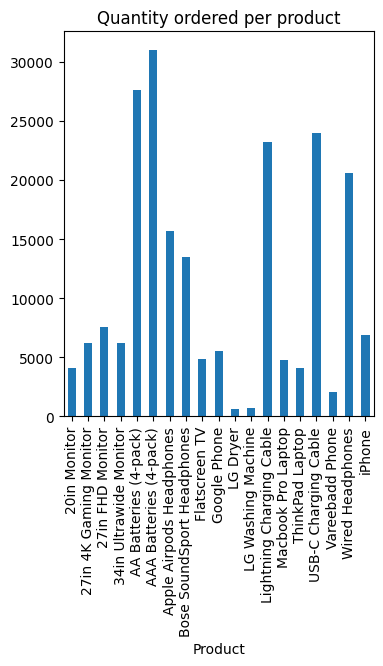

In [ ]:
df.groupby('Product')['Quantity Ordered'].sum().plot.bar(title = 'Quantity ordered per product',figsize =(4,5))

#Sales per month

<Axes: title={'center': ' month wise sales'}, xlabel='Month'>

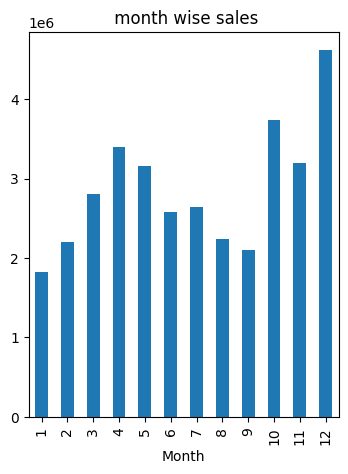

In [ ]:
df.groupby('Month')['Sales'].sum().plot.bar(title = ' month wise sales',figsize = (4,5))

#Sales by location

In [ ]:
city_sales = df.groupby('City')['Sales'].sum().nlargest(5)
city_sales

City
 San Francisco    8262203.91
 Los Angeles      5452570.80
 New York City    4664317.43
 Boston           3661642.01
 Atlanta          2795498.58
Name: Sales, dtype: float64

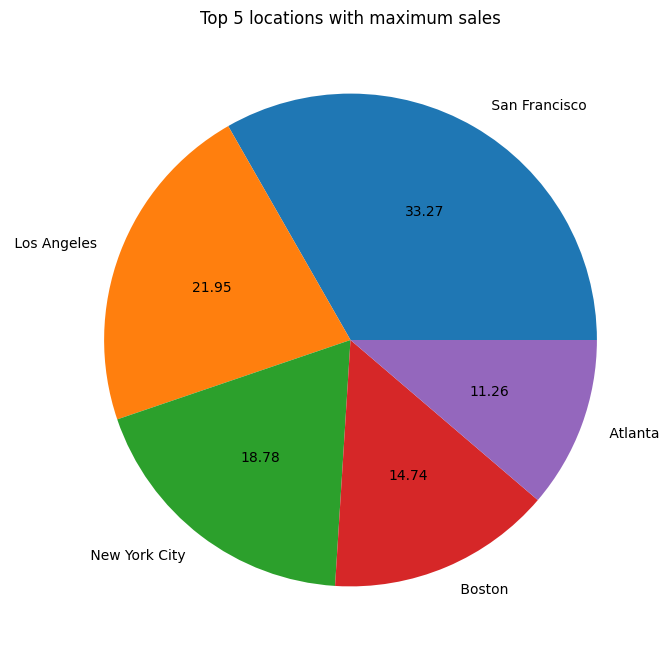

In [ ]:
plt.figure(figsize = (8,8))
plt.title('Top 5 locations with maximum sales')
plt.pie(city_sales,autopct = '%.2f',labels = city_sales.index)
plt.show()

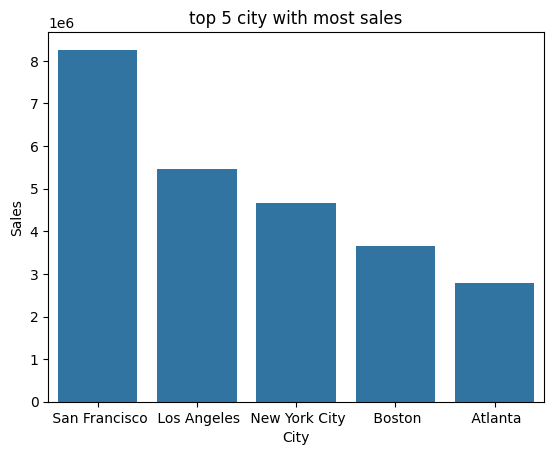

In [ ]:
sns.barplot(x = city_sales.index , y = city_sales).set(title = 'top 5 city with most sales')
plt.show()

#Sales Per Hour

<Axes: title={'center': 'Sales Per Hour'}, xlabel='Hour'>

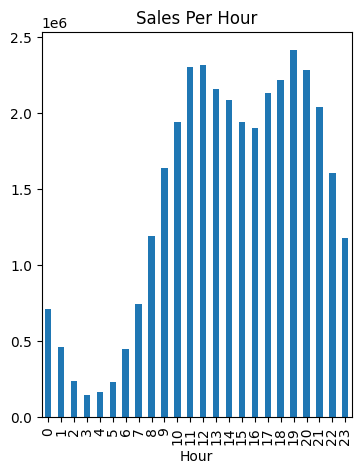

In [ ]:
df.groupby('Hour')['Sales'].sum().plot.bar(title = 'Sales Per Hour',figsize = (4,5))